<h3><center><b>Loading data / Preprocessing</b></center></h3>
<hr>

In [1]:
import pandas as pd
from datetime import dt
import os
import numpy as np

In [2]:
dataset_dir = "house_5" # Choose folder name of the house

labels_file = pd.read_csv(os.path.join(dataset_dir, "labels.dat"), sep=" ", names=["number", "name"])

In [3]:
df_combined = pd.DataFrame()

for idx, appliance in labels_file.iterrows():
    file_path = os.path.join(dataset_dir, f"channel_{appliance['number']}.dat")
    df_temp = pd.read_csv(file_path, sep=" ", names=['timestamp', appliance["name"]])
    
    df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'], unit='s')
    df_temp.set_index('timestamp', inplace=True)
    df_temp_resampled = df_temp.resample('1T').first()

    if df_combined.empty:
        df_combined = df_temp_resampled
    else:
        df_combined = df_combined.join(df_temp_resampled, how='outer')

df_combined.reset_index(inplace=True)

df_combined = df_combined.fillna(0)

In [12]:
df_combined

,timestamp,aggregate,stereo_speakers_bedroom,i7_desktop,hairdryer,primary_tv,24_inch_lcd_bedroom,treadmill,network_attached_storage,core2_server,...,sky_hd_box,kettle,fridge_freezer,oven,electric_hob,dishwasher,microwave,washer_dryer,vacuum_cleaner,state
0,2014-06-29 16:23:00,768.0,1.0,114.0,0.0,69.0,0.0,0.0,18.0,80.0,...,18.0,2.0,108.0,0.0,0.0,0.0,0.0,225.0,0.0,0
1,2014-06-29 16:24:00,777.0,1.0,118.0,0.0,69.0,0.0,0.0,18.0,80.0,...,19.0,2.0,107.0,0.0,0.0,0.0,0.0,262.0,0.0,0
2,2014-06-29 16:25:00,2285.0,1.0,113.0,1.0,68.0,0.0,0.0,18.0,79.0,...,19.0,2.0,106.0,0.0,0.0,0.0,0.0,1439.0,0.0,0
3,2014-06-29 16:26:00,769.0,1.0,115.0,0.0,68.0,0.0,0.0,18.0,79.0,...,18.0,2.0,105.0,0.0,0.0,0.0,0.0,257.0,0.0,0
4,2014-06-29 16:27:00,760.0,1.0,115.0,0.0,69.0,0.0,0.0,18.0,79.0,...,18.0,2.0,105.0,0.0,0.0,0.0,0.0,209.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43015,2014-07-29 13:18:00,549.0,1.0,105.0,0.0,0.0,0.0,0.0,18.0,84.0,...,14.0,2.0,0.0,0.0,0.0,0.0,50.0,14.0,0.0,0
43016,2014-07-29 13:19:00,507.0,1.0,66.0,0.0,0.0,0.0,0.0,18.0,87.0,...,14.0,2.0,0.0,0.0,0.0,0.0,50.0,14.0,0.0,0
43017,2014-07-29 13:20:00,528.0,1.0,65.0,0.0,0.0,0.0,0.0,19.0,85.0,...,14.0,2.0,0.0,0.0,0.0,0.0,50.0,15.0,0.0,0
43018,2014-07-29 13:21:00,522.0,1.0,68.0,1.0,1.0,0.0,0.0,18.0,83.0,...,15.0,2.0,0.0,0.0,0.0,0.0,48.0,14.0,0.0,0


<h3><center><b>Device Analysis</b></center></h3>
<hr>

### Scatter plot of a device (checking what devices to choose)

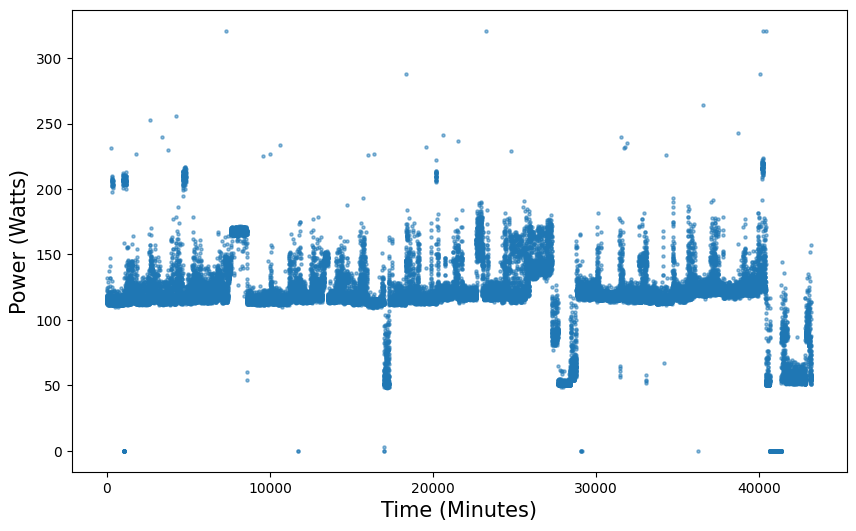

In [8]:
device = 'i7_desktop' # Choose device to analyze

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(df_combined.index, df_combined[device], alpha=0.5, s=5)

plt.xlabel('Time (Minutes)', fontsize=15)
plt.ylabel('Power (Watts)', fontsize=15)

plt.show()

In [73]:
# When we decide, what devices we want to use, write them down and calculate new aggregated field
device_columns = ['kettle', 'rice_cooker', 'washing_machine', 'dish_washer', 'microwave', 'toaster']

df_combined['aggregate'] = df_combined[device_columns].sum(axis=1)

### Only ON and OFF states clustering (two states device)
Depending on number of states for given device, run either the one below for 2 states or under device clustering for more states, after running each of them save clustered states into state column or drop

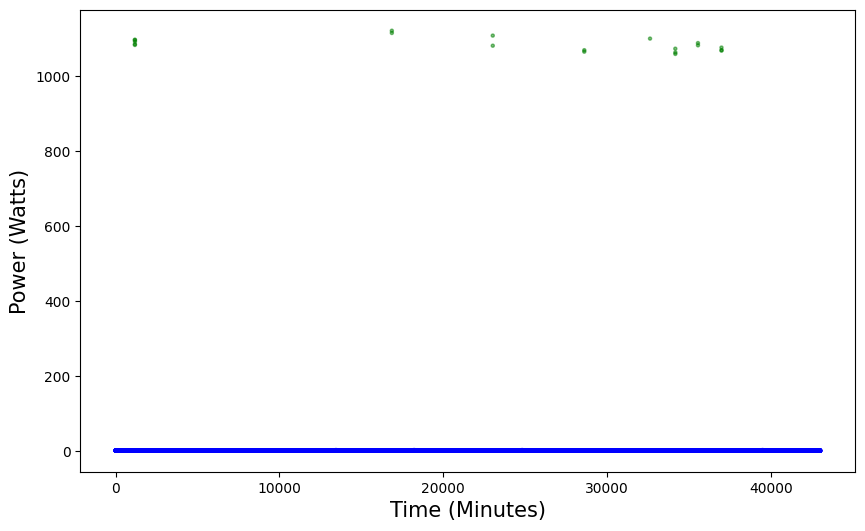

In [13]:
device = "toaster"

def apply_threshold(power):
    if power <= 20:
        return "0"
    else:
        return "1"

df_combined['state'] = df_combined[device].apply(apply_threshold)

plt.figure(figsize=(10, 6))
colors = {'0': 'blue', '1': 'green'}
plt.scatter(df_combined.index, df_combined[device], c=df_combined['state'].apply(lambda x: colors[x]), alpha=0.5, s=5)
plt.ylabel('Power (Watts)', fontsize=15)
plt.xlabel('Time (Minutes)', fontsize=15)
plt.show()


### Device Clustering (multi states devices)
cluster devices into decided number of clusters

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


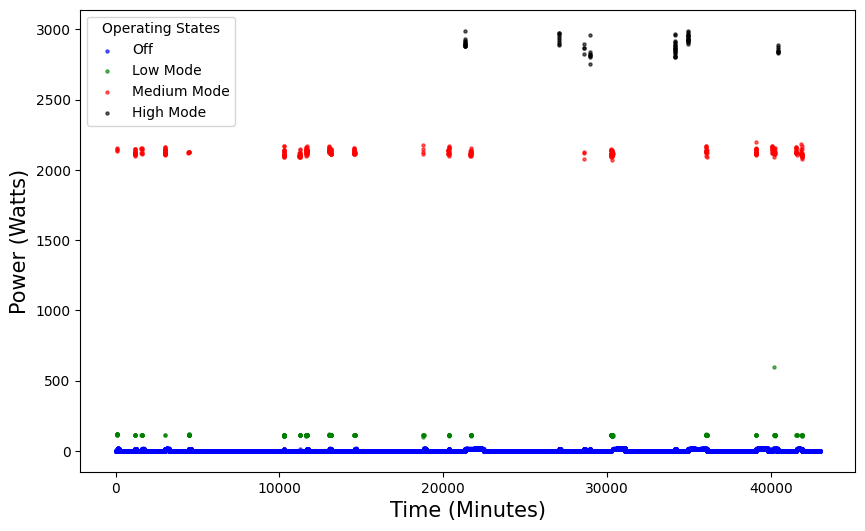

In [11]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

device = 'oven' # Choose device

off_threshold = 20
df_combined['state'] = np.where(df_combined[device] <= off_threshold, 0, -1)

cluster_data = df_combined[df_combined['state'] == -1][device].values.reshape(-1, 1)

if len(cluster_data) > 0:
    kmeans = KMeans(n_clusters=3, random_state=0).fit(cluster_data) # choose n_clusters

    cluster_means = {i: cluster_data[kmeans.labels_ == i].mean() for i in range(kmeans.n_clusters)}
    sorted_labels = sorted(cluster_means, key=cluster_means.get)
    label_map = {sorted_labels[i]: i + 1 for i in range(len(sorted_labels))}
    df_combined.loc[df_combined['state'] == -1, 'state'] = [label_map[x] for x in kmeans.labels_]


# choose accordingly number of chosen states for device (visualisation purpose)

# 3 states (n_clusters=2)
# colors = {0: 'blue', 1: 'green', 2: 'red'}
# labels = {0: 'Off', 1: 'Low Mode', 2: 'High Mode'}

# 4 states (n_clusters=3)
colors = {0: 'blue', 1: 'green', 2: 'red', 3: 'black',}
labels = {0: 'Off', 1: 'Low Mode', 2: 'Medium Mode', 3: 'High Mode'}

# 5 states (n_clusters=4)
# colors = {0: 'blue', 1: 'green', 2: 'red', 3: 'brown', 4:'black'}
# labels = {0: 'Off', 1: 'Low Mode', 2: 'Medium Mode', 3: 'High Mode', 4:'Very High Mode'}

plt.figure(figsize=(10, 6))
for state, color in colors.items():
    subset = df_combined[df_combined['state'] == state]
    plt.scatter(subset.index, subset[device], c=color, alpha=0.6, s=5, label=labels[state])

plt.xlabel('Time (Minutes)', fontsize=15)
plt.ylabel('Power (Watts)', fontsize=15)

plt.legend(title="Operating States", loc='upper left')

plt.show()

### Replacing device column with state

In [65]:
df_combined[device] = df_combined['state']

### Dropping not needed device

In [67]:
df_combined.drop(device, axis=1, inplace=True)

<h3><center><b>Feature selection</b></center></h3>
<hr>

In [80]:
# feature extraction from timestamp

# weekday = 0, weekend = 1
df_combined['what_hour'] = df_combined["timestamp"].dt.hour
df_combined['what_day'] = df_combined['timestamp'].dt.weekday
df_combined['is_weekend'] = df_combined['timestamp'].apply(lambda x: 1 if x.weekday() > 4 else 0)

In [ ]:
# feature extraction from aggregate

device = 'aggregate'

df_combined=df_combined.copy()

off_threshold = 20
df_combined['agg_clustered'] = np.where(df_combined[device] <= off_threshold, 0, -1)

cluster_data = df_combined[df_combined['agg_clustered'] == -1][device].values.reshape(-1, 1)

if len(cluster_data) > 0:
    n_clusters = min(10, len(cluster_data))
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(cluster_data)
    cluster_means = {i: cluster_data[kmeans.labels_ == i].mean() for i in range(kmeans.n_clusters)}
    sorted_labels = sorted(cluster_means, key=cluster_means.get)
    label_map = {sorted_labels[i]: i + 1 for i in range(len(sorted_labels))}
    df_combined.loc[df_combined['agg_clustered'] == -1, 'agg_clustered'] = [label_map[x] for x in kmeans.labels_]

### Convert all columns into int

In [82]:
for col in df_combined:
    if col != 'timestamp':
        df_combined[col] = pd.to_numeric(df_combined[col], errors='coerce')

### Restructuring dataframe

In [84]:
df_combined = df_combined[['timestamp', 'what_hour', 'what_day', 'is_weekend','aggregate', 'agg_clustered','kettle', 'rice_cooker', 'washing_machine', 'dish_washer', 'microwave', 'toaster']]

<h3><center><b>Saving</b></center></h3>
<hr>

In [93]:
# Saving to parquet

import pyarrow  
df_combined.to_parquet('parquets/house2/df_combined1')